In [1]:
import gym
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import copy

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class QClass:
    def __init__(self):
        self.Q = {}
        
    def __getitem__(self, key):
        if key not in self.Q:
            self.Q[key] = []
            for i in key:
                if i == '1':
                    self.Q[key].append(np.random.random())
                else:
                    self.Q[key].append(-10)
        return self.Q[key]

class PI:
    def __init__(self, Q, epsilon, alpha, gamma):
        self.Q = Q
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.last_q = 0
        self.last_state = None
        self.last_action = None
        
    def reset_mem(self):
        self.last_q = 0
        self.last_state = None
        self.last_action = None

    def getActionGreedy(self, s, n=None):
        return np.argmax(self.Q[s])

    def get_epsillon_greedy(self, state, possible_moves, action_to_int):
        dice = np.random.random()
        if (dice > self.epsilon):
            action = self.getActionGreedy(state)
        else:
            index = np.random.randint(0, high=possible_moves.shape[0])
            action = action_to_int(possible_moves[index])

        self.last_action = action
        self.last_state = state
        self.last_q = self.Q[self.last_state][self.last_action]

        return action

    def update_Q(self, reward, state, is_terminal):
        if self.last_state is not None:
            if is_terminal:
                maxQ = 0
            else:
                maxQ = np.max(self.Q[state])
            self.Q[self.last_state][self.last_action] = self.last_q + self.alpha * (
                        reward + self.gamma * maxQ - self.last_q)


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None

        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            #             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----' * (self.n_cols) + '-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----' * (self.n_cols) + '-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

    def get_random_Q(self, verbose=False):
        Q = {}
        iter_object = product('012', repeat=self.n_cols * self.n_rows)
        if verbose:
            iter_object = tqdm(iter_object, total=int(3 ** (self.n_cols * self.n_rows)))

        for s in iter_object:
            s = ''.join(s)
            Q[s] = []
            for i in s:
                if i == '1':
                    Q[s].append(np.random.random())
                else:
                    Q[s].append(-10)
        return Q


In [3]:

def Q_learning_episode(env, pi1=None, pi2=None):
    assert pi1 != None or pi2 != None

    env.reset()
    if pi1 is not None:
        pi1.reset_mem()
    if pi2 is not None:
        pi2.reset_mem()
    state, possible_moves, cur_turn = env.getState()

    done = False
    while not done:
        if cur_turn == 1:
            if pi1 is None:
                assert len(possible_moves.shape) > 0
                index = np.random.randint(0, high=possible_moves.shape[0])
                action = env.int_from_action(possible_moves[index])
            else:
                action = pi1.get_epsillon_greedy(state, possible_moves, env.int_from_action)
        else:
            if pi2 is None:
                index = np.random.randint(0, high=possible_moves.shape[0])
                action = env.int_from_action(possible_moves[index])
            else:
                action = pi2.get_epsillon_greedy(state, possible_moves, env.int_from_action)

        obs, reward, done, info = env.step(env.action_from_int(action))
        assert reward != -10
        state, possible_moves, next_turn = obs

        if not done:
            if cur_turn == 1:
                if pi2 is not None:
                    pi2.update_Q(reward, state, done)
            else:
                if pi1 is not None:
                    pi1.update_Q(reward, state, done)
        else:
            if pi1 is not None:
                pi1.update_Q(reward, state, done)
            if pi2 is not None:
                pi2.update_Q(-reward, state, done)
        cur_turn = next_turn

    return reward


def play_game(env, pi1=None, pi2=None, verbose=False):
    assert pi1 != None or pi2 != None
    env.reset()
    state, possible_moves, cur_turn = env.getState()

    done = False
    while not done:
        if cur_turn == 1:
            if pi1 is None:
                index = np.random.randint(0, high=possible_moves.shape[0])
                action = env.int_from_action(possible_moves[index])
            else:
                action = pi1.getActionGreedy(state)
        else:
            if pi2 is None:
                index = np.random.randint(0, high=possible_moves.shape[0])
                action = env.int_from_action(possible_moves[index])
            else:
                action = pi2.getActionGreedy(state)

        obs, reward, done, info = env.step(env.action_from_int(action))
        state, possible_moves, cur_turn = obs

        if verbose:
            env.printBoard()
            print(env.getHash())

        assert reward != -10

    return reward


def eval_players(env, pi1, pi2, n=10000):
    pi1_wins = 0
    pi2_wins = 0
    draws = 0
    for _ in range(n):
        reward = play_game(env, pi1, pi2)

        if reward == 1:
            pi1_wins += 1
        elif reward == -1:
            pi2_wins += 1
        else:
            draws += 1

    return pi1_wins / n, pi2_wins / n, draws / n



In [8]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
n = 200 * 1000
epsillon = 0.3
gamma = 0.9
alpha = 0.2
verbose_rate = 0.05

int_Q = QClass()
pi1 = PI(copy.deepcopy(int_Q), epsillon, alpha, gamma)
pi2 = PI(copy.deepcopy(int_Q), epsillon, alpha, gamma)

test_rewards = []
train_rewards = []

for i in tqdm(range(n)):
    reward = Q_learning_episode(env, pi1=pi1, pi2=pi2)
    train_rewards.append(reward)
    
    test_rewards.append(eval_players(env, pi1=pi1, pi2=pi2, n=1))
    if i % int(n * verbose_rate) == int(n * verbose_rate) - 1:
        cur_stat = np.asarray(test_rewards[-int(n * verbose_rate):]).mean(axis=0)
        print(f'Cur test stat: p1: {cur_stat[0]}, p2: {cur_stat[1]}, draw: {cur_stat[2]}', flush=True)
        mean_reward = np.asarray(train_rewards[-int(n * verbose_rate):]).mean()
        print(f'Mean train reward: {mean_reward}', flush=True)


Cur test stat: p1: 0.455, p2: 0.2643, draw: 0.2807
Mean train reward: 0.2247
Cur test stat: p1: 0.3287, p2: 0.1353, draw: 0.536
Mean train reward: 0.2362
Cur test stat: p1: 0.1143, p2: 0.024, draw: 0.8617
Mean train reward: 0.2126
Cur test stat: p1: 0.0393, p2: 0.0122, draw: 0.9485
Mean train reward: 0.2099
Cur test stat: p1: 0.018, p2: 0.0045, draw: 0.9775
Mean train reward: 0.1788
Cur test stat: p1: 0.0112, p2: 0.0012, draw: 0.9876
Mean train reward: 0.1992
Cur test stat: p1: 0.0074, p2: 0.0002, draw: 0.9924
Mean train reward: 0.1988
Cur test stat: p1: 0.009, p2: 0.0014, draw: 0.9896
Mean train reward: 0.1797
Cur test stat: p1: 0.0106, p2: 0.0016, draw: 0.9878
Mean train reward: 0.2089
Cur test stat: p1: 0.0121, p2: 0.0004, draw: 0.9875
Mean train reward: 0.1909
Cur test stat: p1: 0.0068, p2: 0.001, draw: 0.9922
Mean train reward: 0.1867
Cur test stat: p1: 0.0029, p2: 0.0004, draw: 0.9967
Mean train reward: 0.1821
Cur test stat: p1: 0.0107, p2: 0.0, draw: 0.9893
Mean train reward: 0.

In [9]:
pi1_score, random_score, draw = eval_players(env, pi1=pi1, pi2=None, n=10000)
print('pi1_score:', pi1_score, 'random_score:', random_score, 'draw:', draw)

pi1_score: 0.9956 random_score: 0.0 draw: 0.0044


In [10]:
pi2_score, random_score, draw = eval_players(env, pi1=None, pi2=pi2, n=10000)
print('pi2_score:', pi2_score, 'random_score:', random_score, 'draw:', draw)

pi2_score: 0.0 random_score: 0.9048 draw: 0.0952


In [11]:
np_test_rewards = np.asarray(test_rewards).reshape(-1, int(n * verbose_rate), 3).mean(axis=1)
np_train_rewards = np.asarray(train_rewards).reshape(-1, int(n * verbose_rate)).mean(axis=1)

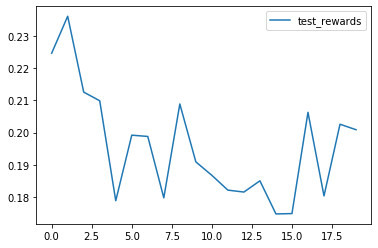

In [12]:
plt.plot(np_train_rewards, label='test_rewards')
plt.legend()
plt.show()

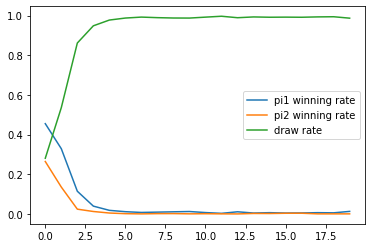

In [13]:
plt.plot(np_test_rewards[:, 0], label='pi1 winning rate')
plt.plot(np_test_rewards[:, 1], label='pi2 winning rate')
plt.plot(np_test_rewards[:, 2], label='draw rate')
plt.legend()
plt.show()

In [14]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

n = 2000 * 1000
epsillon = 0.3
gamma = 0.9
alpha = 0.2
verbose_rate = 0.05

int_Q = QClass()
pi1 = PI(copy.deepcopy(int_Q), epsillon, alpha, gamma)
pi2 = PI(copy.deepcopy(int_Q), epsillon, alpha, gamma)

test_rewards = []
train_rewards = []

for i in tqdm(range(n)):
    reward = Q_learning_episode(env, pi1=pi1, pi2=pi2)
    train_rewards.append(reward)
    
    test_rewards.append(eval_players(env, pi1=pi1, pi2=pi2, n=1))
    if i % int(n * verbose_rate) == int(n * verbose_rate) - 1:
        cur_stat = np.asarray(test_rewards[-int(n * verbose_rate):]).mean(axis=0)
        print(f'Cur test stat: p1: {cur_stat[0]}, p2: {cur_stat[1]}, draw: {cur_stat[2]}', flush=True)
        mean_reward = np.asarray(train_rewards[-int(n * verbose_rate):]).mean()
        print(f'Mean train reward: {mean_reward}', flush=True)





Cur test stat: p1: 0.31256, p2: 0.25383, draw: 0.43361
Mean train reward: 0.05583
Cur test stat: p1: 0.31078, p2: 0.24706, draw: 0.44216
Mean train reward: 0.06054
Cur test stat: p1: 0.30677, p2: 0.24457, draw: 0.44866
Mean train reward: 0.06258
Cur test stat: p1: 0.30674, p2: 0.23003, draw: 0.46323
Mean train reward: 0.07109
Cur test stat: p1: 0.30134, p2: 0.22659, draw: 0.47207
Mean train reward: 0.08131
Cur test stat: p1: 0.30886, p2: 0.22081, draw: 0.47033
Mean train reward: 0.08051
Cur test stat: p1: 0.30845, p2: 0.21495, draw: 0.4766
Mean train reward: 0.08521
Cur test stat: p1: 0.30826, p2: 0.22193, draw: 0.46981
Mean train reward: 0.08581
Cur test stat: p1: 0.31406, p2: 0.20609, draw: 0.47985
Mean train reward: 0.09325
Cur test stat: p1: 0.30834, p2: 0.22143, draw: 0.47023
Mean train reward: 0.09554
Cur test stat: p1: 0.29681, p2: 0.21389, draw: 0.4893
Mean train reward: 0.09669
Cur test stat: p1: 0.30641, p2: 0.20311, draw: 0.49048
Mean train reward: 0.10041
Cur test stat: p

In [19]:
pi1_score, random_score, draw = eval_players(env, pi1=pi1, pi2=None, n=40000)
print('pi1_score:', pi1_score, 'random_score:', random_score, 'draw:', draw)

pi1_score: 0.4235 random_score: 0.17345 draw: 0.40305


In [18]:
pi2_score, random_score, draw = eval_players(env, pi1=None, pi2=pi2, n=40000)
print('pi2_score:', pi2_score, 'random_score:', random_score, 'draw:', draw)

pi2_score: 0.248175 random_score: 0.3223 draw: 0.429525


In [15]:
np_test_rewards = np.asarray(test_rewards).reshape(-1, int(n * verbose_rate), 3).mean(axis=1)
np_train_rewards = np.asarray(train_rewards).reshape(-1, int(n * verbose_rate)).mean(axis=1)

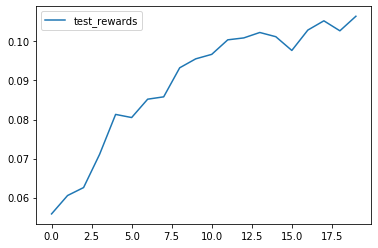

In [20]:
plt.plot(np_train_rewards, label='test_rewards')
plt.legend()
plt.show()

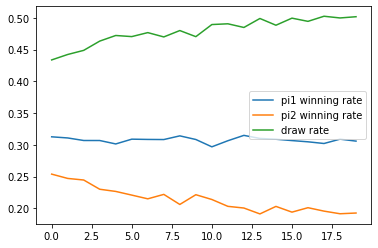

In [21]:
plt.plot(np_test_rewards[:, 0], label='pi1 winning rate')
plt.plot(np_test_rewards[:, 1], label='pi2 winning rate')
plt.plot(np_test_rewards[:, 2], label='draw rate')
plt.legend()
plt.show()

# Часть 2

In [4]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import random
import math

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class Network(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(9, layer_size)
        self.l2 = nn.Linear(layer_size, 9)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [36]:
class TicTacToeDQN():
    def __init__(self):
        self.env = TicTacToe(3, 3, 3)
        self.model = Network()
        self.memory = ReplayMemory(10000)
        
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        
        self.gamma = 0.9
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
        self.reset_short_mem()
        self.loss_history = []
        
    def reset_short_mem(self):
        self.last_state = None
        self.last_action = None
        
    def select_greedy_action(self, state):
#         print('greedy')
        int_action = self.model(state).data.max(1)[1].view(1, 1)[0][0]
        return torch.tensor(env.action_from_int(int_action))
    
    def select_action(self, state, possible_moves, save_prev=False):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            action = self.select_greedy_action(state)
        else:
            index = np.random.randint(0, high=possible_moves.shape[0])
            action = torch.tensor(possible_moves[index], dtype=torch.int64)
            
        if save_prev:
            self.last_state = state.detach().clone()
            self.last_action = action.detach().clone()

        return action
                
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_is_done = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_is_done = Variable(torch.cat(batch_is_done))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).reshape([self.batch_size])
        
        if (abs(Q) > 1000).any():
            print(Q)
            assert False

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax) * (1  - batch_is_done)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.loss_history.append(loss.item())

In [41]:
def run_episode(env, cross_model, nought_model, e=0, do_learning=True, greedy=False, render=False, verbose=False):
    env.reset()
    cross_model.reset_short_mem()
    nought_model.reset_short_mem()
    hash_state, possible_moves, cur_turn = env.getState()
    state = env.board.flatten()
    num_step = 0
    
    done = False
    while not done:
        if render:
            env.printBoard()
            
        if cur_turn == 1:
            cur_model = cross_model
            next_model = nought_model
        else:
            cur_model = nought_model
            next_model = cross_model
    
        state_tensor = torch.tensor([state], dtype=torch.float32)
        with torch.no_grad():
            if greedy:
                action = cur_model.select_greedy_action(state_tensor)
            else:
                action = cur_model.select_action(state_tensor, possible_moves, save_prev=True)
#         print(action)
        obs, reward, done, _ = env.step(action.numpy())
        state = env.board.flatten()
        state_tensor = torch.tensor([state], dtype=torch.float32)

        if done:
            if reward == -10:
                transition = (cur_model.last_state, torch.tensor([env.int_from_action(cur_model.last_action)]), 
                              state_tensor, torch.tensor([reward], dtype=torch.float32), torch.tensor([done], dtype=int))
                cur_model.memory.store(transition)
                
                if do_learning:
                    cur_model.learn()
            else:
                cross_model.memory.store((cross_model.last_state, torch.tensor([env.int_from_action(cross_model.last_action)]), 
                                          state_tensor, torch.tensor([reward], dtype=torch.float32), torch.tensor([done], dtype=int)))
                nought_model.memory.store((nought_model.last_state, torch.tensor([env.int_from_action(nought_model.last_action)]), 
                                           state_tensor, torch.tensor([-reward], dtype=torch.float32), torch.tensor([done], dtype=int)))

                if do_learning:
                    cross_model.learn()
                    nought_model.learn()
        elif next_model.last_state is not None:
            transition = (next_model.last_state, torch.tensor([env.int_from_action(next_model.last_action)]), 
                          state_tensor, torch.tensor([reward], dtype=torch.float32), torch.tensor([done], dtype=int))
            next_model.memory.store(transition)
            
            if do_learning:
                next_model.learn()


        hash_state, possible_moves, cur_turn = obs
        num_step += 1


In [38]:
def test_vs_random(env, model, player, n_tests=10000):
    wins = 0
    losses = 0
    draws = 0
    errors = 0
    for _ in range(n_tests):
        env.reset()
        hash_state, possible_moves, cur_turn = env.getState()
        state = env.board.flatten()
        done = False
        
        while not done:
            state_tensor = torch.tensor([state], dtype=torch.float32)
            if cur_turn == player:
                with torch.no_grad():
#                     print(state_tensor)
#                     print(model.model(state_tensor).data)
                    action = model.select_greedy_action(state_tensor)
            else:
                index = np.random.randint(0, high=possible_moves.shape[0])
                action = torch.tensor(possible_moves[index], dtype=torch.int64)
            obs, reward, done, _ = env.step(action.numpy())
            hash_state, possible_moves, cur_turn = obs
            state = env.board.flatten()
            
        if reward == player:
            wins +=1
        elif reward == -player:
            losses += 1
        elif reward == 0:
            draws += 1
        else:
            errors += 1
        
    return wins / n_tests, losses / n_tests, draws / n_tests, errors / n_tests

In [39]:
model1, model2 = TicTacToeDQN(), TicTacToeDQN()
env = model1.env

In [44]:
verbose_rate = 0.05
n = 12000
cycle_length = int(verbose_rate * n)

for e in tqdm(range(n)):
    run_episode(env, model1, model2, e=e)
    if e % cycle_length == cycle_length - 1:
        print(np.mean(model1.loss_history[-cycle_length:]))
        stata = test_vs_random(env, model1, player=1, n_tests=100)
        print(f'Win rate: {stata[0]}, Lose rate: {stata[1]}, Draw rate: {stata[2]}, Error rate {stata[3]}')

0.03412587304289142
Win rate: 0.94, Lose rate: 0.03, Draw rate: 0.03, Error rate 0.0
0.03184718045250823
Win rate: 0.93, Lose rate: 0.0, Draw rate: 0.07, Error rate 0.0
0.02663952225043128
Win rate: 0.99, Lose rate: 0.0, Draw rate: 0.01, Error rate 0.0
0.02461785699163253
Win rate: 0.99, Lose rate: 0.0, Draw rate: 0.01, Error rate 0.0
0.02500040303915739
Win rate: 0.98, Lose rate: 0.0, Draw rate: 0.02, Error rate 0.0
0.022417480091098695
Win rate: 0.99, Lose rate: 0.0, Draw rate: 0.01, Error rate 0.0
0.01931431856472045
Win rate: 0.98, Lose rate: 0.0, Draw rate: 0.02, Error rate 0.0
0.017591773097325736
Win rate: 1.0, Lose rate: 0.0, Draw rate: 0.0, Error rate 0.0
0.014750567547356088
Win rate: 0.92, Lose rate: 0.03, Draw rate: 0.05, Error rate 0.0
0.014447452555177733
Win rate: 0.98, Lose rate: 0.0, Draw rate: 0.02, Error rate 0.0
0.016486984881339595
Win rate: 0.87, Lose rate: 0.0, Draw rate: 0.13, Error rate 0.0
0.02050777373602614
Win rate: 0.91, Lose rate: 0.02, Draw rate: 0.07, E

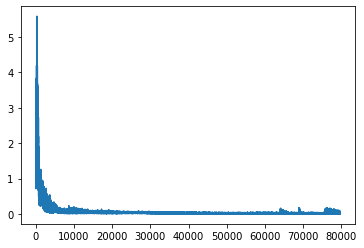

In [45]:
plt.plot(np.asarray(model1.loss_history))
plt.show()

In [46]:
stata = test_vs_random(env, model1, player=1, n_tests=10000)
print(f'Win rate: {stata[0]}, Lose rate: {stata[1]}, Draw rate: {stata[2]}, Error rate {stata[3]}')

Win rate: 0.9854, Lose rate: 0.0, Draw rate: 0.0126, Error rate 0.002


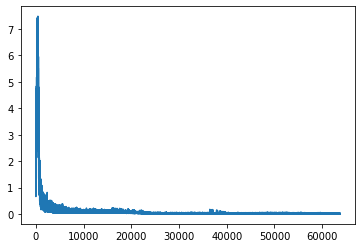

In [47]:
plt.plot(np.asarray(model2.loss_history))
plt.show()

In [48]:
stata = test_vs_random(env, model2, player=-1, n_tests=10000)
print(f'Win rate: {stata[0]}, Lose rate: {stata[1]}, Draw rate: {stata[2]}, Error rate {stata[3]}')

Win rate: 0.8536, Lose rate: 0.0059, Draw rate: 0.1405, Error rate 0.0
